## CLASSIFICATION model applied to the prediction of class for premiumAmount
by Rumiya Al-Meri

## 1. Import & preprocess

For preprocessing the "helpers" file is used which includes the helping functions created by JL.

In [1]:
# Import the needed functions and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) #allow display of all columns
from helpers import convert_columns_to_datetime, \
                    get_unique_values, \
                    generate_country_region_mapping, \
                    time_delta_month, \
                    add_last_pA_infos, \
                    merge_pA_infos,\
                    map_zones,\
                    cache
from preprocessing import preprocessing_df

In [2]:
#Import the preprocessed data frame
df = pd.read_csv('SalesData_preprocessed.csv', low_memory=False)

#show head()
df.head()

,BirthDate,Nation,AgeAtPremium,PolicyAgeAtPremium,policy_StartDate,policy_EffEndDate,premiumAmount,FeeAmount,feeRate,ContractID,product_code,MainProductCode,MainProductName,Model,Zone,ZoneDesc,premium_Country,premium_CountryName,product_group,product_groupName,premiumMonth,Model_Zone,Nation_region,premiumCountry_region,policy_startMonth,policyAge_months,pA_lastDate,pA_currentPremium,pA_lastPremium,pA_last_Change,pA_new_model,time_since_last_pA
0,1994-10-06,PL,20,0,2014-10-20,2015-08-31,-82.95,-33.18,40%,p7642,Q055.001.000,G007,Product6,1001,1004,Deutschland,DE,Germany,100,Produkte,2014-11-01,1001 - Deutschland,Europe,DE,2014-10,1,NaN,NaN,NaN,NaN,NaN,0.0
1,1979-02-20,PL,35,1,2013-06-01,2015-08-31,79.00,31.60,40%,p4253,Q055.001.000,G007,Product6,1001,1004,Deutschland,DE,Germany,100,Produkte,2014-11-01,1001 - Deutschland,Europe,DE,2013-06,17,NaN,NaN,NaN,NaN,NaN,0.0
2,1987-08-13,DE,27,0,2014-08-13,2019-07-31,79.00,31.60,40%,p7287,Q055.001.000,G007,Product6,1001,1002,Ohne USA / CAN,TH,Thailand,100,Produkte,2014-11-01,1001 - Ohne USA / CAN,DE,Asia,2014-08,3,NaN,NaN,NaN,NaN,NaN,0.0
3,1984-05-25,PT,30,0,2014-04-01,2015-08-31,79.00,31.60,40%,p6407,Q055.001.000,G007,Product6,1001,1004,Deutschland,DE,Germany,100,Produkte,2014-11-01,1001 - Deutschland,Europe,DE,2014-04,7,NaN,NaN,NaN,NaN,NaN,0.0
4,1978-09-30,PL,36,0,2014-07-06,2018-09-30,79.00,31.60,40%,p7027,Q055.001.000,G007,Product6,1001,1004,Deutschland,DE,Germany,100,Produkte,2014-11-01,1001 - Deutschland,Europe,DE,2014-07,4,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
#convert datecolumn dtypes
date_cols = ['BirthDate','policy_StartDate', 'policy_EffEndDate','premiumMonth','policy_startMonth', 'pA_lastDate']
df = convert_columns_to_datetime(df, date_cols)

#print info & column names
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195857 entries, 0 to 195856
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   BirthDate              195857 non-null  datetime64[ns]
 1   Nation                 195857 non-null  object        
 2   AgeAtPremium           195857 non-null  int64         
 3   PolicyAgeAtPremium     195857 non-null  int64         
 4   policy_StartDate       195857 non-null  datetime64[ns]
 5   policy_EffEndDate      195857 non-null  datetime64[ns]
 6   premiumAmount          195857 non-null  float64       
 7   FeeAmount              195857 non-null  float64       
 8   feeRate                195857 non-null  object        
 9   ContractID             195857 non-null  object        
 10  product_code           195857 non-null  object        
 11  MainProductCode        195857 non-null  object        
 12  MainProductName        195857 non-null  obje

Index(['BirthDate', 'Nation', 'AgeAtPremium', 'PolicyAgeAtPremium',
       'policy_StartDate', 'policy_EffEndDate', 'premiumAmount', 'FeeAmount',
       'feeRate', 'ContractID', 'product_code', 'MainProductCode',
       'MainProductName', 'Model', 'Zone', 'ZoneDesc', 'premium_Country',
       'premium_CountryName', 'product_group', 'product_groupName',
       'premiumMonth', 'Model_Zone', 'Nation_region', 'premiumCountry_region',
       'policy_startMonth', 'policyAge_months', 'pA_lastDate',
       'pA_currentPremium', 'pA_lastPremium', 'pA_last_Change', 'pA_new_model',
       'time_since_last_pA'],
      dtype='object')

## 2. Create a data frame

Step 1: Create a data frame with the target values: number of unique ContractID and the sum of premium amounts per month. Then, create and add features.

In [4]:
#Import the functions to pre-process the data from the 'helpers'
from helpers import groupby_and_apply, plot_grouped_data, plot_line_plots

#Create a df with the premium month, the target variable sum of premium amounts and the count of unique ClientIDs
apply = {'premiumAmount': 'sum', 'ContractID': 'nunique'}
target_df = groupby_and_apply(df, group_cols= ['premiumMonth'], apply=apply)
target_df.head()

,premiumMonth,sum_premiumAmount,nunique_ContractID
0,2014-11-01,105259.0,1245
1,2014-12-01,107333.0,1264
2,2015-01-01,109588.0,1287
3,2015-02-01,113145.0,1327
4,2015-03-01,117564.0,1379


In [5]:
#Get a description of the main target value: sum of premium amounts
target_df['sum_premiumAmount'].describe()

count       110.000000
mean     144823.945455
std       25954.333356
min       60230.000000
25%      136896.500000
50%      150026.000000
75%      161238.500000
max      177682.000000
Name: sum_premiumAmount, dtype: float64

(array([ 6.,  0.,  0.,  2.,  4.,  6., 25., 19., 26., 22.]),
 array([ 60230. ,  71975.2,  83720.4,  95465.6, 107210.8, 118956. ,
        130701.2, 142446.4, 154191.6, 165936.8, 177682. ]),
 <BarContainer object of 10 artists>)

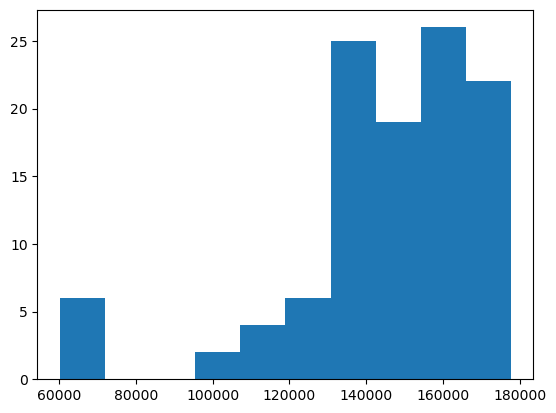

In [6]:
#Visualisation of its values distribution
import matplotlib.pyplot as plt
plt.hist(target_df['sum_premiumAmount'])

Mainly the target variable takes the value between 130 701 and 177 682.

In [7]:
#Now, we separate the target value into the bins for further predictions of the target value taking a value within one of the bins.
#This is done with the help of qcut. We decided to cut into the 4 bins due to the distribution, mean and quartiles.
target_df['bin_freq'] = pd.qcut(target_df['sum_premiumAmount'], q=4, precision=1, labels=['XS', 'S', 'M', 'L'])
target_df.head(50)

,premiumMonth,sum_premiumAmount,nunique_ContractID,bin_freq
0,2014-11-01,105259.0,1245,XS
1,2014-12-01,107333.0,1264,XS
2,2015-01-01,109588.0,1287,XS
3,2015-02-01,113145.0,1327,XS
4,2015-03-01,117564.0,1379,XS
5,2015-04-01,119105.0,1394,XS
6,2015-05-01,120459.0,1410,XS
7,2015-06-01,122612.0,1430,XS
8,2015-07-01,124179.0,1456,XS
9,2015-08-01,130232.0,1512,XS


In [8]:
#Get a description of the 'bin_freq' to check how the cut was done
target_df['bin_freq'].describe()

count     110
unique      4
top        XS
freq       28
Name: bin_freq, dtype: object

Step 2: Create and add features: mean value for AgeAtPremium, mean value for policyAge_months and the rolling mean of the sum of premiumAmount of the previous 12 months.

Unfortunately, we cannot take the ZoneUnited as a feature as after we group the data by month we cannot define a featire from the ZoneUnited which would make sence.

In [9]:
#Add additonal variables to target DF
apply = {'ContractID': 'nunique', 'premiumAmount': 'sum', 'AgeAtPremium': 'mean', 'policyAge_months': 'mean'}
target_df_added = groupby_and_apply(df, group_cols= ['premiumMonth'], apply=apply)
target_df_added['bin_freq'] = pd.qcut(target_df_added['sum_premiumAmount'], q=4, precision=1, labels=['XS', 'S', 'M', 'L'])

# Drop the last FC values for the months: June - Dec'23 as the values are not well predicted
target_df_added.drop(target_df_added.tail(7).index,inplace=True)
target_df_added.head(50)

,premiumMonth,nunique_ContractID,sum_premiumAmount,mean_AgeAtPremium,mean_policyAge_months,bin_freq
0,2014-11-01,1245,105259.0,36.355572,8.201668,XS
1,2014-12-01,1264,107333.0,36.611896,8.764312,XS
2,2015-01-01,1287,109588.0,36.466765,9.259232,XS
3,2015-02-01,1327,113145.0,36.525521,9.597412,XS
4,2015-03-01,1379,117564.0,36.407056,9.665536,XS
5,2015-04-01,1394,119105.0,36.320161,10.154052,XS
6,2015-05-01,1410,120459.0,36.544977,10.690742,XS
7,2015-06-01,1430,122612.0,36.618252,11.217224,XS
8,2015-07-01,1456,124179.0,36.772584,11.545167,XS
9,2015-08-01,1512,130232.0,36.913709,11.793146,XS


In [10]:
# Calculate the rolling mean of the last 12 months for 'sum_premiumAmount'
target_df_added['sum_premiumAmount_prev12months'] = target_df_added['sum_premiumAmount'].rolling(window=12, min_periods=1).mean()

#Display the data frame 
target_df_added.head(20)

,premiumMonth,nunique_ContractID,sum_premiumAmount,mean_AgeAtPremium,mean_policyAge_months,bin_freq,sum_premiumAmount_prev12months
0,2014-11-01,1245,105259.0,36.355572,8.201668,XS,105259.000000
1,2014-12-01,1264,107333.0,36.611896,8.764312,XS,106296.000000
2,2015-01-01,1287,109588.0,36.466765,9.259232,XS,107393.333333
3,2015-02-01,1327,113145.0,36.525521,9.597412,XS,108831.250000
4,2015-03-01,1379,117564.0,36.407056,9.665536,XS,110577.800000
5,2015-04-01,1394,119105.0,36.320161,10.154052,XS,111999.000000
6,2015-05-01,1410,120459.0,36.544977,10.690742,XS,113207.571429
7,2015-06-01,1430,122612.0,36.618252,11.217224,XS,114383.125000
8,2015-07-01,1456,124179.0,36.772584,11.545167,XS,115471.555556
9,2015-08-01,1512,130232.0,36.913709,11.793146,XS,116947.600000


In [11]:
# Calculate the correlation matrix
correlation_matrix = target_df_added.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                                nunique_ContractID  sum_premiumAmount  \
nunique_ContractID                        1.000000           0.851428   
sum_premiumAmount                         0.851428           1.000000   
mean_AgeAtPremium                         0.102285           0.521231   
mean_policyAge_months                     0.351509           0.566847   
sum_premiumAmount_prev12months            0.654712           0.884829   

                                mean_AgeAtPremium  mean_policyAge_months  \
nunique_ContractID                       0.102285               0.351509   
sum_premiumAmount                        0.521231               0.566847   
mean_AgeAtPremium                        1.000000               0.743257   
mean_policyAge_months                    0.743257               1.000000   
sum_premiumAmount_prev12months           0.629179               0.802347   

                                sum_premiumAmount_prev12months  
nunique_ContractID 

<AxesSubplot:>

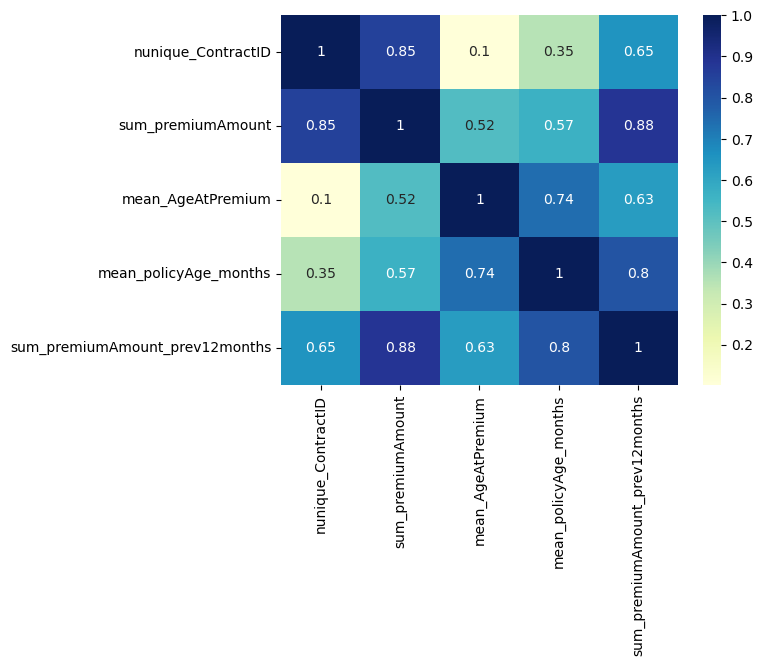

In [13]:
#Plot the correlation matrix
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")

There is no much correlation between the target variable sum_premiumAmount and the features created such as mean_AgeAtPremium and mean_policyAge_months. The target variable correlate with the number of unique ClientID and the mean of sum_permiumAmount within the last rolling 12 months which is not surprising. 

Number of unique ClientID as shown previously has a direct impact on the sum of premiumAmount but cannot be taken as a feature as we do not know how many unique clients we will have in the future.
We still will try to build a classification model with the 2 features we have and the calculated mean of sum of the premiumAmount in the last 12 months. As the last one is known and can be taken into the model.

## 3. MODELLING on the target_df_added

### 3.1. MODELLING on the target_df_added with KNN:

In [18]:
### Modelling with KNN

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import datasets

## 1. K-Neighbors

# Create df as descriptive variables and target as a target variable

df_x =  target_df_added.drop('nunique_ContractID', axis = 1)
df_x =  target_df_added.drop('sum_premiumAmount', axis = 1)
df_x =  target_df_added.drop( 'bin_freq', axis = 1)
target = target_df_added['bin_freq']

target_df_added['premiumMonth'] = target_df_added[('premiumMonth')].values.astype('float64')

In [19]:
#Check the data frame and its columns.
df_x.info()
df_x.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   premiumMonth                    103 non-null    float64
 1   nunique_ContractID              103 non-null    int64  
 2   sum_premiumAmount               103 non-null    float64
 3   mean_AgeAtPremium               103 non-null    float64
 4   mean_policyAge_months           103 non-null    float64
 5   sum_premiumAmount_prev12months  103 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 5.0 KB


Index(['premiumMonth', 'nunique_ContractID', 'sum_premiumAmount',
       'mean_AgeAtPremium', 'mean_policyAge_months',
       'sum_premiumAmount_prev12months'],
      dtype='object')

In [31]:
# Devide df into test and train datasets

X_train, X_test, y_train, y_test = train_test_split(df_x, target, test_size = 0.2)

#Creating a knn-model and fit it on the training set using different metrics. THe Chebyshev is the first one to check.

knn_cheb = neighbors.KNeighborsClassifier(n_neighbors=7, metric = 'chebyshev')
knn_cheb.fit(X_train, y_train)

#Predict with the use of the knn-model applying it to the test data & display the confustion matrix

y_pred = knn_cheb.predict(X_test)
pd.crosstab(y_test, y_pred, rownames = ['Class real'], colnames = ['Class predicted'])


C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Class predicted,L,M,S,XS
Class real,,,,
XS,0,0,0,5
S,0,0,4,0
M,0,6,1,0
L,5,0,0,0


Except for one value the model with chebyshev metric predicted all other values right.

In [26]:
#Creating a knn-model and fit it on the training set with the metric manhattan.

knn_m = neighbors.KNeighborsClassifier(n_neighbors=3, metric = 'manhattan')
knn_m.fit(X_train, y_train)

#Predict with the use of the knn-model applying it to the test data & display the confustion matrix

y_pred = knn_m.predict(X_test)
pd.crosstab(y_test, y_pred, rownames = ['Class real'], colnames = ['Class predicted'])


C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Class predicted,L,M,S,XS
Class real,,,,
XS,0,0,0,3
S,0,0,4,0
M,0,5,0,0
L,9,0,0,0


Metric manhattan works betetr here. All values are right predicted.

In [27]:
#Creating a knn-model and fit it on the training set with the metric Minkowski.

knn_mink = neighbors.KNeighborsClassifier(n_neighbors=5, metric = 'minkowski')
knn_mink.fit(X_train, y_train)

#Predict with the use of the knn-model applying it to the test data & display the confustion matrix

y_pred = knn_mink.predict(X_test)
pd.crosstab(y_test, y_pred, rownames = ['Class real'], colnames = ['Class predicted'])

C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Class predicted,L,M,S,XS
Class real,,,,
XS,0,0,0,3
S,0,0,4,0
M,0,5,0,0
L,9,0,0,0


KNN-model with the metric minkowski shows the same results as with the metric manhattan. All values are right predicted.

In [32]:
#Create the same model with different n_neighbors = 5 and different metrics, apply the model and check the accurace.

score_chebyshev = knn_cheb.score(X_test, y_test)
score_manhattan = knn_m.score(X_test, y_test)
score_minkowski = knn_mink.score(X_test, y_test)
score_chebyshev, score_manhattan, score_minkowski

C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

(0.9523809523809523, 1.0, 0.9523809523809523)

The highest accuracy is achieved with the knn-model by the metric manhattan. Still we will do the modelling for different k-s and metrics to find the best combination and optimize the performance.

In [42]:
#Run the modelling for different k-s and metrics to optimize the preformance
# Create lists where we will store the accuracy scores for three different models
score_minko = []
score_man = []
score_cheb = []

for k in range(1, 20):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    score_minko.append(knn.score(X_test, y_test))

for k in range(1, 20):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append(knn.score(X_test, y_test))
    
for k in range(1, 20):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train, y_train)
    score_cheb.append(knn.score(X_test, y_test))   


C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rumiy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

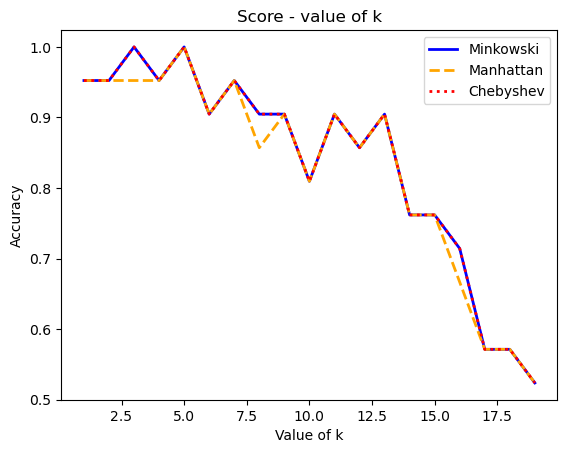

In [43]:
# Visualize it on the plot to see which k and metric gives the best accuracy score.
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1,20), score_minko, color = 'blue', linestyle = 'solid', lw=2, label = 'Minkowski')
plt.plot(range(1,20), score_man, color = 'orange', linestyle = 'dashed', lw=2, label = 'Manhattan')
plt.plot(range(1,20), score_cheb, color = 'red', linestyle = 'dotted', lw=2, label = 'Chebyshev')
plt.title('Score - value of k')
plt.xlabel('Value of k')
plt.ylabel('Accuracy')
plt.legend();

The highest accuracy is achieved for all metrics with the k=5 as well as for the metrics Minkowski and Chebyshev with the k=3.

### 3.2. MODELLING on the target_df_added with SVM:

In [44]:
# Modelling with SVM
#Import the necessary moduls fomr sklearn
#Scale the X_train

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [45]:
#Print mean and standard deviation
print(X_train_scaled.mean(axis=0), X_train_scaled.std(axis=0))

[-9.93785000e-16  7.39246063e-16  3.27651185e-16 -2.97864714e-16
  5.03662153e-16  4.27842044e-16] [1. 1. 1. 1. 1. 1.]


In [49]:
#Scale the X_test and calculate the mean and standard deviation
scaler = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled.mean(axis=0)) 
print(X_test_scaled.std(axis=0))

[ 9.25185854e-16  3.51570624e-16  5.65685065e-16  6.17495473e-15
 -8.67031314e-16 -3.64787565e-16]
[1. 1. 1. 1. 1. 1.]


In [47]:
#Import the necessary svm moduls from sklearn
from sklearn import svm
from sklearn import model_selection

#Build the svm model and train it
clf = svm.SVC(gamma=0.01, kernel = "poly")
clf.fit(X_train_scaled, y_train)

SVC(gamma=0.01, kernel='poly')

In [50]:
#Now predict on the test set
y_pred=clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=["Class real"], colnames=['Class predicted'])

Class predicted,L,S
Class real,,
XS,2,3
S,2,2
M,7,0
L,5,0


We got very bad results with this model. We need to find the best possible values for the parameters to improve on results.

In [51]:
#Create a dictionary parameters containing the possible values taken for the parameter C:[0.1,1,10], for kernel: ['rbf', 'linear', 'poly'] and for gamma:[0.001, 0.1, 0.5].
#Find the best combination of the parameters
parameters={"C":[0.1,1,10], "kernel": ['rbf', 'linear', 'poly'], "gamma":[0.001, 0.1, 0.5]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parameters)

#Train on the training set, save in the object grid and show the best parameters
grid=grid_clf.fit(X_train_scaled, y_train)

print(grid_clf.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [52]:
#Making class predictions using the grid_clf model on the test set and store them in the y_pred variable
y_pred=grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=["Class real"], colnames=["Class predicted"])

Class predicted,L,M,S,XS
Class real,,,,
XS,0,0,0,5
S,0,0,4,0
M,0,6,1,0
L,5,0,0,0


Now we got better results with the combination of best parameters. Only 1 value was wrongly predicted.

In [53]:
#Import necessary modules from sklearn.metrics
from sklearn.metrics import accuracy_score

# Calculate accuracy for this model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9523809523809523


The accuracy for SVM-model is the same as for the KNN-model with chebyshev and minkowski metrics.

## 4. Conclusion on the application of the K-neighbours and SVM - learning models.

As we have only a limited number of features which are not so good correlated with the target variable only except for the rolling mean of the sum_premiumAmount of the previous 12 months, these two models cannot be applied in the real life. Other models such as time series for a premiumAmount prediction are to be considered or the target variable should be rather churn predictions than the premiumAmount class predictions.

Still the results in case of KNN-model with the metric manhattan and the k=3 or k=5 are the best - the highest accuracy. 